### **Model Development**

---

### **Project Setup**

In [77]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer

# Training and Evaluations
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, make_scorer

# Hyper-parameter Tuning and Cross Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline 

# Import machine learning models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [8]:
# Read the dataset
df = pd.read_csv("credit_card_fraud.csv")
df.head()

,transaction_time,credit_card_number,merchant,category,transaction_amount,gender,street,city,state,zip,...,job,transaction_number,is_fraud,full_name,age,transaction_location,merchant_location,transaction_hour,distance_km,is_nighttime
0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,...,"Psychologist, counselling",0b242abb623afc578575680df30655b9,0,Jennifer Banks,31,"-81.1781, 36.0788","-82.048315, 36.011293",0,78.597568,1
1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,...,Special educational needs teacher,1f76529f8574734946361c461b024d99,0,Stephanie Gill,41,"-118.2105, 48.8878","-118.186462, 49.159046999999994",0,30.212176,1
2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,...,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,0,Edward Sanchez,57,"-112.262, 42.1808","-112.154481, 43.150704",0,108.206083,1
3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,...,Patent attorney,6b849c168bdad6f867558c3793159a81,0,Jeremy White,52,"-112.1138, 46.2306","-112.561071, 47.034331",0,95.673231,1
4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,...,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,0,Tyler Garcia,33,"-79.4629, 38.4207","-78.632459, 38.674999",0,77.556744,1


In [9]:
# Dataset information 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   transaction_time      object 
 1   credit_card_number    int64  
 2   merchant              object 
 3   category              object 
 4   transaction_amount    float64
 5   gender                object 
 6   street                object 
 7   city                  object 
 8   state                 object 
 9   zip                   int64  
 10  city_population       int64  
 11  job                   object 
 12  transaction_number    object 
 13  is_fraud              int64  
 14  full_name             object 
 15  age                   int64  
 16  transaction_location  object 
 17  merchant_location     object 
 18  transaction_hour      int64  
 19  distance_km           float64
 20  is_nighttime          int64  
dtypes: float64(2), int64(7), object(12)
memory usage: 296.8+ MB


In [10]:
# Change data types
df["transaction_time"] = pd.to_datetime(df["transaction_time"])
df["credit_card_number"] = df["credit_card_number"].astype(str)
df["zip"] = df["zip"].astype(str)
df["is_fraud"] = df["is_fraud"].astype(str)
df["is_nighttime"] = df["is_nighttime"].astype(str)

In [11]:
# Descriptive statistics on numerical features
df.describe().T

,count,mean,min,25%,50%,75%,max,std
transaction_time,1852394,2020-01-20 21:31:46.801827328,2019-01-01 00:00:18,2019-07-23 04:13:43.750000128,2020-01-02 01:15:31,2020-07-23 12:11:25.249999872,2020-12-31 23:59:34,NaN
transaction_amount,1852394.0,70.063567,1.0,9.64,47.45,83.1,28948.9,159.253975
city_population,1852394.0,88643.674509,23.0,741.0,2443.0,20328.0,2906700.0,301487.618344
age,1852394.0,46.21138,14.0,33.0,44.0,57.0,96.0,17.395446
transaction_hour,1852394.0,12.806119,0.0,7.0,14.0,19.0,23.0,6.815753
distance_km,1852394.0,76.111726,0.022255,55.320087,78.21638,98.509467,152.117173,29.11697


In [12]:
# Descriptive statistics on categorical features
df.describe(include='object').T

,count,unique,top,freq
credit_card_number,1852394,999,6538441737335434,4392
merchant,1852394,693,Kilback LLC,6262
category,1852394,14,gas_transport,188029
gender,1852394,2,F,1014749
street,1852394,999,444 Robert Mews,4392
city,1852394,906,Birmingham,8040
state,1852394,51,TX,135269
zip,1852394,985,82514,5116
job,1852394,497,Film/video editor,13898
transaction_number,1852394,1852394,0b242abb623afc578575680df30655b9,1


**Dataset Description**: This dataset was intially used inside the notebook file for exploratory data analysis to understand and gain more insights of fraud transactions. There were some cleaning and new columns added and now we will use this dataset to do preprocessing before fitting into the models.

---

### **Data Preprocessing**

In [13]:
# Get only necessary columns
features = ["transaction_amount", "is_nighttime", "category", "transaction_location", "job", "state", "is_fraud"]
df = df[features]
df.columns

Index(['transaction_amount', 'is_nighttime', 'category',
       'transaction_location', 'job', 'state', 'is_fraud'],
      dtype='object')

In [17]:
# Define the categorical features
low_cardinality_features = ["category", "is_nighttime"]
high_cardinality_features = ["transaction_location", "job", "state"]

# Define processing pipeline 
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_onehot", OneHotEncoder(drop="first", sparse_output=False), low_cardinality_features),
        ("car_target", TargetEncoder(), high_cardinality_features),
    ],
    remainder="passthrough"
)

In [66]:
# Handle class imbalance by sampling 
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

# Convert target variable to numeric
y = y.astype(int)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Use SMOTE for oversampling the minority class (fraud)
sampling_strategy = 0.1
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Create a pipeline with preprocessing and SMOTE
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", smote)
])

In [67]:
# Apply preprocessing and resampling to training 
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [76]:
# Check the shape of resampled dataset 
print("Minority class before oversampling", y_train[y_train == 1].count())
print("Minority class after oversampling", y_train_resampled[y_train_resampled == 1].count())

Minority class before oversampling 7721
Minority class after oversampling 147419


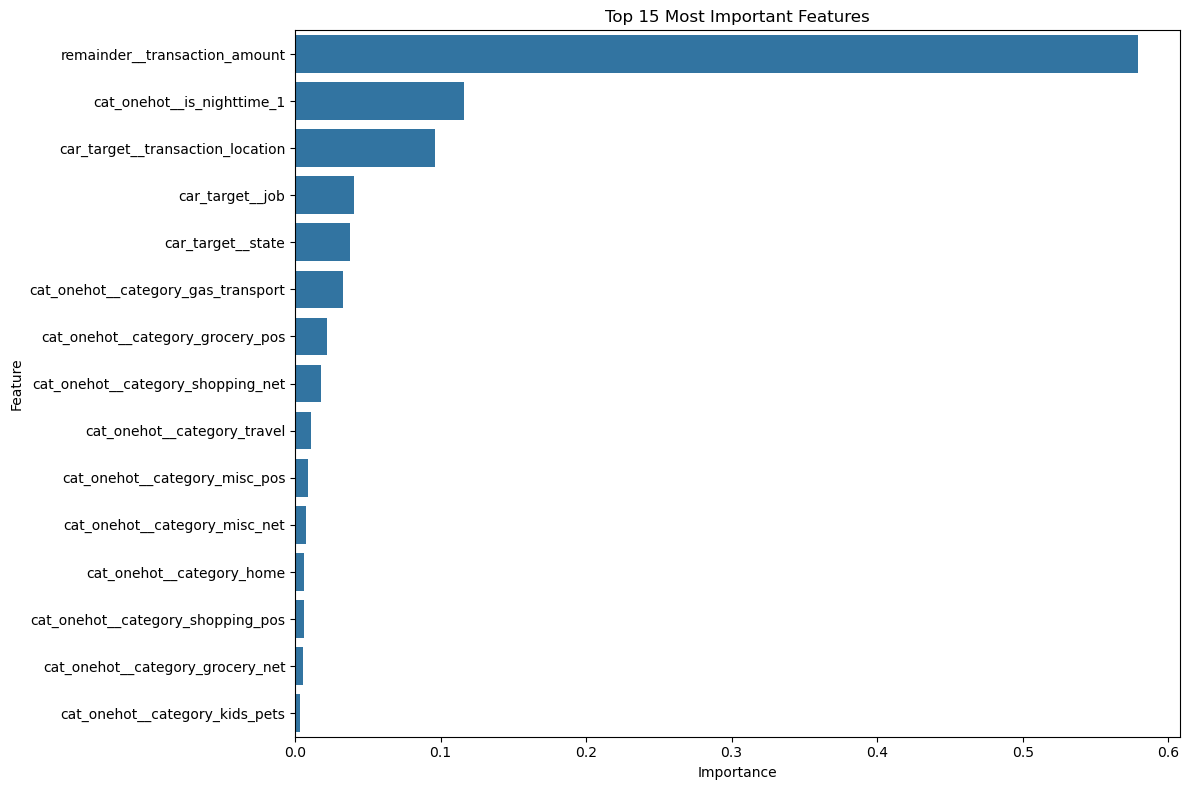

In [70]:
# Feature importance analysis 
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Get feature importance
feature_names = preprocessor.get_feature_names_out()
importance = rf.feature_importances_

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

In [ ]:
# Create final preprocessing pipeline 
final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("feature_selector", SelectFromModel(rf, threshold='median')),
    ("smote", smote)
])

# Pipeline for testing 
test_pipeline = Pipeline([
    ("preprocessor", final_pipeline.named_steps["preprocessor"]),
    ("feature_selector", final_pipeline.named_steps["feature_selector"])
])

# Apply final preprocessing and resampling to training data
X_train_final, y_train_final = final_pipeline.fit_resample(X_train, y_train)

# Transform test data (without fit)
X_test_final = test_pipeline.transform(X_test)

In [73]:
# Check the shape of transformed train and test data
print("Transformed training data shape:", X_train_final.shape)
print("Transformd testing data shape:", X_test_final.shape)

Transformed training data shape: (1621613, 9)
Transformd testing data shape: (370479, 9)


### **Model Training & Evaluation**

In [ ]:
# Setup the StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics for evaluation 
scoring = {
    "precision": make_scorer(precision_score, pos_label=1),
    "recall": make_scorer(recall_score, pos_label=1),
    "f1": make_scorer(f1_score, pos_label=1)
}

# Create pipeline 
full_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selector", SelectFromModel(rf, threshold='median')),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Perform cross-validation
cv_results = cross_validate(estimator=full_pipeline, X=X_train, y=y_train,
                            cv=skf, scoring=scoring, return_train_score=True)

# Display cross-validation results
for metric in scoring.keys():
    print(f"CV {metric} - Mean: {cv_results[f"test_{metric}"].mean():.4f}")

CV precision - Mean: 0.8140
CV recall - Mean: 0.6622
CV f1 - Mean: 0.7303
